# Single Replica TIS

This notebook shows how to run single replica TIS move scheme. This assumes you can load engine, network, and initial sample from a previous calculation.

In [1]:
%matplotlib inline
import openpathsampling as paths
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from openpathsampling.visualize import PathTreeBuilder, PathTreeBuilder
from IPython.display import SVG, HTML

def ipynb_visualize(movevis):
    """Default settings to show a movevis in an ipynb."""
    view = movevis.renderer
    view.zoom = 1.5
    view.scale_y = 18
    view.scale_th = 20
    view.font_size = 0.4
    return view

Open the storage and load things from it.

In [3]:
old_store = paths.AnalysisStorage("mstis.nc")
#old_store = paths.Storage("mstis.nc")  # if not actually doing analysis, but loading network, etc

In [4]:
network = old_store.networks[0]
engine = old_store.engines[0]
template = old_store.snapshots[0]

One of the points of SRTIS is that we use a bias (which comes from an estimate of the crossing probability) in order to improve our sampling.

In [5]:
# this is how we would get it out of a simulation (although the actual simulation here has bad stats)
# first, we need the crossing probabilities, which we get when we calculate the rate
network.hist_args['max_lambda'] = { 'bin_width' : 0.02, 'bin_range' : (0.0, 0.5) }
network.hist_args['pathlength'] = { 'bin_width' : 5, 'bin_range' : (0, 150) }
rates = network.rate_matrix(old_store.steps)

In [6]:
# just use the analyzed network to make the bias
bias = paths.SRTISBiasFromNetwork(network)
bias.df

,Out A 0,Out A 1,Out A 2,Out B 0,Out B 1,Out B 2,Out C 0,Out C 1,Out C 2,[UnionEnsemble]
Out A 0,1,5.55807,12.6306,NaN,NaN,NaN,NaN,NaN,NaN,8.36144
Out A 1,0.179919,1,2.27247,NaN,NaN,NaN,NaN,NaN,NaN,1.50438
Out A 2,0.0791731,0.44005,1,NaN,NaN,NaN,NaN,NaN,NaN,0.662001
Out B 0,NaN,NaN,NaN,1,4.72747,20.705,NaN,NaN,NaN,20.7706
Out B 1,NaN,NaN,NaN,0.21153,1,4.37972,NaN,NaN,NaN,4.3936
Out B 2,NaN,NaN,NaN,0.0482976,0.228325,1,NaN,NaN,NaN,1.00317
Out C 0,NaN,NaN,NaN,NaN,NaN,NaN,1,1.35946,3.5222,1.50439
Out C 1,NaN,NaN,NaN,NaN,NaN,NaN,0.735587,1,2.59089,1.10661
Out C 2,NaN,NaN,NaN,NaN,NaN,NaN,0.283913,0.385968,1,0.427116
[UnionEnsemble],0.119597,0.664726,1.51057,0.0481449,0.227604,0.99684,0.664722,0.903661,2.34128,1


In [7]:
# For better stats, use the results that I got from a 20k MC step run
# We can create fake TCPs and force them on the network.

tcp_A = paths.analysis.LookupFunction.from_dict(
    {0.2: 1.0,
     0.3: 0.13293104100673198,
     0.4: 0.044370838092911397,
     0.5: 0.021975696374764188}
)
tcp_B = paths.analysis.LookupFunction.from_dict(
    {0.2: 1.0,
     0.3: 0.13293104100673198,
     0.4: 0.044370838092911397,
     0.5: 0.021975696374764188}
)
tcp_C = paths.analysis.LookupFunction.from_dict(
    {0.2: 1.0,
     0.3: 0.19485705066078274,
     0.4: 0.053373003923696649,
     0.5: 0.029175949467020165}
)

# load states for identification purposes
stateA = old_store.volumes['A']
stateB = old_store.volumes['B']
stateC = old_store.volumes['C']

# use the sampling transitions; in MSTIS, these are also stored in from_state
network.from_state[stateA].tcp = tcp_A
network.from_state[stateB].tcp = tcp_B
network.from_state[stateC].tcp = tcp_C

In [8]:
bias = paths.SRTISBiasFromNetwork(network)
bias.df

,Out A 0,Out A 1,Out A 2,Out B 0,Out B 1,Out B 2,Out C 0,Out C 1,Out C 2,[UnionEnsemble]
Out A 0,1,7.5227,22.5373,NaN,NaN,NaN,NaN,NaN,NaN,15.1683
Out A 1,0.132931,1,2.99591,NaN,NaN,NaN,NaN,NaN,NaN,2.01633
Out A 2,0.0443708,0.333788,1,NaN,NaN,NaN,NaN,NaN,NaN,0.673029
Out B 0,NaN,NaN,NaN,1,7.5227,22.5373,NaN,NaN,NaN,15.1683
Out B 1,NaN,NaN,NaN,0.132931,1,2.99591,NaN,NaN,NaN,2.01633
Out B 2,NaN,NaN,NaN,0.0443708,0.333788,1,NaN,NaN,NaN,0.673029
Out C 0,NaN,NaN,NaN,NaN,NaN,NaN,1,5.13197,18.7361,11.4249
Out C 1,NaN,NaN,NaN,NaN,NaN,NaN,0.194857,1,3.65085,2.22623
Out C 2,NaN,NaN,NaN,NaN,NaN,NaN,0.053373,0.273909,1,0.609783
[UnionEnsemble],0.0659271,0.49595,1.48582,0.0659271,0.49595,1.48582,0.0875278,0.44919,1.63993,1


Here we actually set up the SRTIS move scheme for the given network. It only requires one line:

In [9]:
scheme = paths.SRTISScheme(network, bias=bias, engine=engine)

Now we'll visualize the SRTIS move scheme.

In [10]:
movevis = paths.visualize.MoveTreeBuilder()
#movevis.mover(scheme.move_decision_tree(), network.all_ensembles)
#SVG(ipynb_visualize(movevis).to_svg())

Next we need to set up an appropriate single-replica initial sampleset. We'll take the last version of from one of the outer TIS ensembles.

In [11]:
final_samp0 = old_store.steps[len(old_store.steps)-1].active[network.sampling_ensembles[-1]]

In [12]:
sset = paths.SampleSet([final_samp0])

Finally, we set up the new storage file and the new simulation. 

In [13]:
storage = paths.Storage("srtis.nc", "w", use_uuid=old_store.reference_by_uuid)
storage.save(template)

(store.snapshots[BaseSnapshot],
 3,
 UUID('0f121d7a-5fb4-11e6-b807-000000003405'))

In [14]:
srtis = paths.PathSampling(
    storage=storage,
    sample_set=sset,
    move_scheme=scheme
)

In [15]:
n_steps_to_run = int(scheme.n_steps_for_trials(
        mover=scheme.movers['minus'][0], 
        n_attempts=1
    ))
print n_steps_to_run

1230


In [16]:
# logging creates ops_output.log file with details of what the calculation is doing
import logging.config
logging.config.fileConfig("logging.conf", disable_existing_loggers=False)

In [17]:
%%time
multiplier = 2
srtis.run_until(multiplier*n_steps_to_run)

Working on Monte Carlo cycle number 2460.
DONE! Completed 2460 Monte Carlo cycles.
CPU times: user 1min 12s, sys: 3.88 s, total: 1min 16s
Wall time: 2min 16s


In [18]:
#storage.close()

From here, we'll be doing the analysis of the SRTIS run.

In [19]:
%%time
#storage = paths.AnalysisStorage("srtis.nc")
#scheme = storage.schemes[0]

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [20]:
scheme.move_summary(storage.steps)

Null moves for 2224 cycles. Excluding null moves:
ms_outer_shooting ran 0.000% (expected 4.07%) of the cycles with acceptance 0/0 (nan%)
repex ran 25.316% (expected 36.59%) of the cycles with acceptance 8/60 (13.33%)
shooting ran 44.304% (expected 36.59%) of the cycles with acceptance 81/105 (77.14%)
minus ran 6.329% (expected 2.44%) of the cycles with acceptance 15/15 (100.00%)
pathreversal ran 24.051% (expected 20.33%) of the cycles with acceptance 56/57 (98.25%)


In [21]:
scheme.move_summary(storage.steps, 'shooting')

Null moves for 2224 cycles. Excluding null moves:
OneWayShootingMover Out A 2 ran 2.110% (expected 4.07%) of the cycles with acceptance 3/5 (60.00%)
OneWayShootingMover Out A 0 ran 35.021% (expected 4.07%) of the cycles with acceptance 65/83 (78.31%)
OneWayShootingMover Out B 0 ran 0.000% (expected 4.07%) of the cycles with acceptance 0/0 (nan%)
OneWayShootingMover Out B 2 ran 0.000% (expected 4.07%) of the cycles with acceptance 0/0 (nan%)
OneWayShootingMover Out C 0 ran 0.000% (expected 4.07%) of the cycles with acceptance 0/0 (nan%)
OneWayShootingMover Out C 1 ran 0.000% (expected 4.07%) of the cycles with acceptance 0/0 (nan%)
OneWayShootingMover Out A 1 ran 7.173% (expected 4.07%) of the cycles with acceptance 13/17 (76.47%)
OneWayShootingMover Out C 2 ran 0.000% (expected 4.07%) of the cycles with acceptance 0/0 (nan%)
OneWayShootingMover Out B 1 ran 0.000% (expected 4.07%) of the cycles with acceptance 0/0 (nan%)


In [22]:
scheme.move_summary(storage.steps, 'minus')

Null moves for 2224 cycles. Excluding null moves:
SingleReplicaMinus ran 6.329% (expected 0.81%) of the cycles with acceptance 15/15 (100.00%)
SingleReplicaMinus ran 0.000% (expected 0.81%) of the cycles with acceptance 0/0 (nan%)
SingleReplicaMinus ran 0.000% (expected 0.81%) of the cycles with acceptance 0/0 (nan%)


In [23]:
scheme.move_summary(storage.steps, 'repex')

Null moves for 2224 cycles. Excluding null moves:
EnsembleHop Out A 1->Out A 2 ran 0.844% (expected 2.03%) of the cycles with acceptance 0/2 (0.00%)
EnsembleHop Out A 2->Out A 1 ran 0.844% (expected 2.03%) of the cycles with acceptance 1/2 (50.00%)
EnsembleHop Out B 1->Out B 0 ran 0.000% (expected 2.03%) of the cycles with acceptance 0/0 (nan%)
EnsembleHop Out C 0->Out C 1 ran 0.000% (expected 2.03%) of the cycles with acceptance 0/0 (nan%)
EnsembleHop Out B 0->Out B 1 ran 0.000% (expected 2.03%) of the cycles with acceptance 0/0 (nan%)
EnsembleHop Out B 2->Out B 1 ran 0.000% (expected 2.03%) of the cycles with acceptance 0/0 (nan%)
EnsembleHop Out C 1->Out C 2 ran 0.000% (expected 2.03%) of the cycles with acceptance 0/0 (nan%)
EnsembleHop Out A 1->Out A 0 ran 4.641% (expected 2.03%) of the cycles with acceptance 4/11 (36.36%)
EnsembleHop [UnionEnsemble]->Out A 2 ran 0.000% (expected 2.03%) of the cycles with acceptance 0/0 (nan%)
EnsembleHop [UnionEnsemble]->Out B 2 ran 0.000% (expec

In [24]:
scheme.move_summary(storage.steps, 'pathreversal')

Null moves for 2224 cycles. Excluding null moves:
PathReversal ran 0.000% (expected 2.03%) of the cycles with acceptance 0/0 (nan%)
PathReversal ran 2.110% (expected 2.03%) of the cycles with acceptance 5/5 (100.00%)
PathReversal ran 5.907% (expected 2.03%) of the cycles with acceptance 13/14 (92.86%)
PathReversal ran 0.000% (expected 2.03%) of the cycles with acceptance 0/0 (nan%)
PathReversal ran 0.000% (expected 2.03%) of the cycles with acceptance 0/0 (nan%)
PathReversal ran 0.000% (expected 2.03%) of the cycles with acceptance 0/0 (nan%)
PathReversal ran 16.034% (expected 2.03%) of the cycles with acceptance 38/38 (100.00%)
PathReversal ran 0.000% (expected 2.03%) of the cycles with acceptance 0/0 (nan%)
PathReversal ran 0.000% (expected 2.03%) of the cycles with acceptance 0/0 (nan%)
PathReversal ran 0.000% (expected 2.03%) of the cycles with acceptance 0/0 (nan%)


In [25]:
replica = storage.samplesets[0].samples[0].replica
ensemble_trace = paths.trace_ensembles_for_replica(replica, storage.steps)
print len(ensemble_trace)

2461


In [26]:
srtis_ensembles = scheme.network.sampling_ensembles+scheme.network.special_ensembles['ms_outer'].keys()
srtis_ensemble_numbers = {e : srtis_ensembles.index(e) for e in srtis_ensembles}
# this next is just for pretty printing
srtis_numbers_ensemble = {srtis_ensemble_numbers[e] : e for e in srtis_ensemble_numbers}
for k in sorted(srtis_numbers_ensemble.keys()):
    print k, ":", srtis_numbers_ensemble[k].name

0 : Out B 0
1 : Out B 1
2 : Out B 2
3 : Out C 0
4 : Out C 1
5 : Out C 2
6 : Out A 0
7 : Out A 1
8 : Out A 2
9 : [UnionEnsemble]


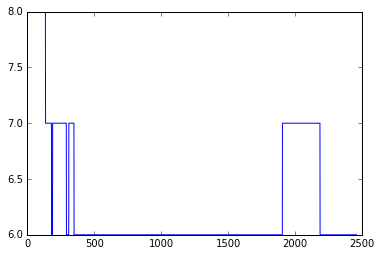

In [27]:
plt.plot([srtis_ensemble_numbers[e] for e in ensemble_trace])

In [28]:
count = 0
for i in range(len(ensemble_trace)-1):
    [this_val, next_val] = [srtis_ensemble_numbers[ensemble_trace[k]] for k in [i,i+1]]
    if this_val == 1 and next_val == 0:
        count += 1
count

0

In [29]:
hist_numbers = [srtis_ensemble_numbers[e] for e in ensemble_trace]
bins = [i-0.5 for i in range(len(srtis_ensembles)+1)]

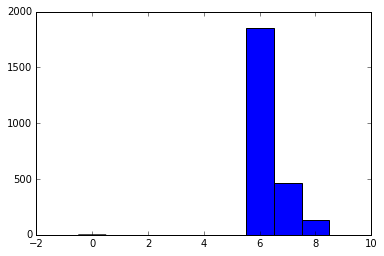

In [30]:
plt.hist(hist_numbers, bins=bins);

In [31]:
import pandas as pd
hist = paths.analysis.Histogram(bin_width=1.0, bin_range=[-0.5,9.5])
colnames = {i : srtis_numbers_ensemble[i].name for i in range(len(srtis_ensembles))}
df = pd.DataFrame(columns=[colnames[i] for i in colnames])

In [32]:
for i in range(len(hist_numbers)):
    hist.add_data_to_histogram([hist_numbers[i]])
    if i % 100 == 0:
        normalized = hist.normalized()
        local_df = pd.DataFrame([normalized.values()], index=[i], columns=[colnames[k] for k in normalized.keys()])
        df = df.append(local_df)

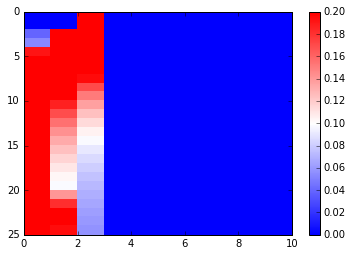

In [33]:
plt.pcolormesh(df.fillna(0.0), cmap="bwr", vmin=0.0, vmax=0.2);
plt.gca().invert_yaxis()
plt.colorbar()